In [1]:
import re
import os
import time
import h5py
import string
import pickle
import datetime
import javalang
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as tfh
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from dpu_utils.mlutils import Vocabulary
from bert.tokenization import FullTokenizer
from gensim.models import KeyedVectors as word2vec
from sklearn.model_selection import train_test_split

In [2]:
MODEL_TYPE = 'cnn'

# Data acquisition

In [3]:
LANGUAGE = "java" #"python"
DATA_PATH = "../../Data/code2desc"
DATA_FOLDER = f"{LANGUAGE}/short"
TRAIN_FILE  = f"{LANGUAGE}_train_0.jsonl"
TEST_FILE   = f"{LANGUAGE}_test_0.jsonl"
VALID_FILE  = f"{LANGUAGE}_valid_0.jsonl"

use_cols = ["code", "docstring"]

In [4]:
def read_data(scope, n_splits):
    def get_file(scope, split_ind):
        return pd.read_json(f"{DATA_PATH}/{DATA_FOLDER}/{LANGUAGE}_{scope}_{split_ind}.jsonl", lines=True)[use_cols]
    
    train_df = get_file(scope, split_ind=0)
    for i in range(1, n_splits):
        train_df = train_df.append(get_file(scope, split_ind=i), ignore_index=True)
    return train_df

This TF Hub model uses the implementation of BERT from the TensorFlow Models repository on GitHub at <a href="https://github.com/tensorflow/models/tree/master/official/nlp/bert">tensorflow/models/official/nlp/bert</a>. It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads.

This model has been pre-trained for English on the Wikipedia and BooksCorpus using the code published on GitHub. Inputs have been "uncased", meaning that the text has been lower-cased before tokenization into word pieces, and any accent markers have been stripped. For training, random input masking has been applied independently to word pieces (as in the original BERT paper).

All parameters in the module are trainable, and fine-tuning all parameters is the recommended practice.

### Descriptions embeddings

In [5]:
model_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"
bert_layer = tfh.KerasLayer(model_url, trainable=False)

In [6]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

### Source code embeddings

In [7]:
# EMBEDDINGS_FOLDER = "source-code-embeddings"
# TOKEN_EMBEDDINGS  = "token_vecs.txt"
# TARGET_EMBEDDINGS = "target_vecs.txt"

# vectors_text_path = f'{EMBEDDINGS_FOLDER}/{TOKEN_EMBEDDINGS}'
# pretrained_sc_emb = word2vec.load_word2vec_format(vectors_text_path, binary=False)

# Data preprocessing

In [5]:
def cleaning(text):
    '''Performs cleaning of text of unwanted symbols, 
    excessive spaces and transfers to lower-case
    '''

    # {@link FaultMessageResolver} => link
    text = re.sub(r"\{?@(\w+)\s+\S+\}?", r'\1', text)
    # delete XML tags 
    text = re.sub(r'<[\/a-zA-Z]+>', "", text)
    # remove excessive spaces
#     text = re.sub(r'\s+', " ", text)
    
    text = ''.join(character for character in text if character in string.printable)
    text = text.lower().strip()

    return text

In [9]:
def generate_bert_input(text, max_seq_length):
    
    tokenized_text = [["[CLS]"] + tokenizer.tokenize(seq)[:max_seq_length-2] + ["[SEP]"] for seq in text]
    input_ids   = [tokenizer.convert_tokens_to_ids(tokens_seq) for tokens_seq in tokenized_text]
    input_mask  = [[1] * len(input_seq) for input_seq in input_ids]
    segment_ids = [[0] * max_seq_length for _ in range(len(input_ids))]
    input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=max_seq_length, padding='post', truncating='post')
    input_mask = tf.keras.preprocessing.sequence.pad_sequences(input_mask, maxlen=max_seq_length, padding='post', truncating='post')
    segment_ids = tf.keras.preprocessing.sequence.pad_sequences(segment_ids, maxlen=max_seq_length, padding='post', truncating='post')

    return input_ids, input_mask, segment_ids

In [10]:
def check_and_fix_code_validity(train_df):
    valid_inds = []
    for i,s_code in enumerate(train_df.code):
        try:
            javalang.parse.parse_member_signature(s_code)
            valid_inds.append(True)
        except javalang.parser.JavaSyntaxError:
            try:
                modified_s_code = s_code + '\n}'
                javalang.parse.parse_member_signature(modified_s_code)
                valid_inds.append(True)
                train_df.code[i] = modified_s_code
            except javalang.parser.JavaSyntaxError:
                valid_inds.append(False)
    return valid_inds

def split_java_token(cstr, camel_case=True, split_char='_'):
    res_split = []

    if camel_case:
        res_split = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', cstr)).split()
    
    if split_char:
        char_splt = []
        if not camel_case:
            res_split = [cstr]
        for token in res_split:
            char_splt += token.split(split_char)
        res_split = char_splt
    return [token for token in res_split if len(token) > 0]

def tokenize_java_code(cstr, stop_tokens=None):
    if not stop_tokens:
        stop_tokens = []
    return [token for plain_token in javalang.tokenizer.tokenize(cstr)\
            if not plain_token.value in stop_tokens \
            for token in split_java_token(plain_token.value, camel_case=True, split_char='_')]

def generate_sc_input(sc_inputs, max_seq_length, max_vocab_size=10000, use_vocab=None):
    
#     def word_to_index(word):
#         word_val = emb_model.vocab.get(word, None)
#         word_index = word_val.index if word_val else None
#         return word_index
    
    stop_tokens = {'{', '}', ';', ',', '(', ')', '.'}
    input_ids = [tokenize_java_code(sc_input, stop_tokens)[:max_seq_length] \
                    for sc_input in sc_inputs]
    
    all_ids = [input_ids]
    all_tokens = []
    for token_list in all_ids:
        for lst in token_list:
            all_tokens += lst
    
    if use_vocab:
        sc_vocab = use_vocab
    else:
        sc_vocab = Vocabulary.create_vocabulary(all_tokens,
                                                max_size=max_vocab_size,
                                                count_threshold=int(len(sc_inputs)*0.00025),
                                                add_pad=True)
    
    input_ids   = [sc_vocab.get_id_or_unk_multiple(sc_input, pad_to_size=max_seq_length) for sc_input in input_ids]
    return sc_vocab, input_ids

In [11]:
def generate_inputs(scope='train', n_splits=1, use_vocab=None):
    pddf = read_data(scope=scope, n_splits=n_splits)
    valid_inds = check_and_fix_code_validity(pddf)
    pddf = pddf[valid_inds]
    pddf.docstring = pddf.docstring.apply(cleaning)
    
    desc_word_ids, desc_input_mask, desc_segment_ids = generate_bert_input(pddf.docstring, desc_max_seq_length)
    sc_vocab, sc_tok_ids = generate_sc_input(pddf.code,
                                            sc_max_seq_length,
                                            sc_max_vocab_size,
                                            use_vocab=use_vocab)
    return desc_word_ids, desc_input_mask, desc_segment_ids, sc_tok_ids, pddf, sc_vocab 

In [12]:
def write_hdf5_data(dataset, dataset_name, data_folder='preprocessed_data'):
    with h5py.File(f'{DATA_PATH}/{data_folder}/{MODEL_TYPE}_encoder/{dataset_name}.h5', 'w') as hf:
        hf.create_dataset(dataset_name, data=dataset)

        
def read_hdf5_data(dataset_name, data_folder='preprocessed_data', start_index=0, end_index=-1):
    with h5py.File(f'{DATA_PATH}/{data_folder}/{MODEL_TYPE}_encoder/{dataset_name}.h5', "r") as f:
        dataset = f[dataset_name]
        end_index = end_index if end_index > 0 else dataset.size
        res = dataset[start_index:end_index]
    return res

In [13]:
sc_max_seq_length = 180 # train_df.code_tokens.apply(len).quantile(0.9) == 225
sc_max_vocab_size = 15000
# sc_max_vocab_size = len(pretrained_sc_emb.vocab)

desc_max_seq_length = 180 # 0.95 quantile == 178

pddf = read_data(scope='train', n_splits=16)
valid_inds = check_and_fix_code_validity(pddf)
pddf = pddf[valid_inds]
pddf.docstring = pddf.docstring.apply(cleaning)

desc_word_ids, desc_input_mask, desc_segment_ids = generate_bert_input(pddf.docstring, desc_max_seq_length)

In [14]:
write_hdf5_data(desc_word_ids, 'desc_noparam_word_ids')
write_hdf5_data(desc_input_mask, 'desc_noparam_input_mask')

In [15]:
pddf = read_data(scope='valid', n_splits=1)
valid_inds = check_and_fix_code_validity(pddf)
pddf = pddf[valid_inds]
pddf.docstring = pddf.docstring.apply(cleaning)

desc_word_ids, desc_input_mask, desc_segment_ids = generate_bert_input(pddf.docstring, desc_max_seq_length)

In [16]:
write_hdf5_data(desc_word_ids, 'v_desc_noparam_word_ids')
write_hdf5_data(desc_input_mask, 'v_desc_noparam_input_mask')

In [45]:
print(pddf1.docstring[ind])

Constructs a {@code LinkedHashMultimap} with the same mappings as the specified multimap. If a
key-value mapping appears multiple times in the input multimap, it only appears once in the
constructed multimap. The new multimap has the same {@link Multimap#entries()} iteration order
as the input multimap, except for excluding duplicate mappings.

@param multimap the multimap whose contents are copied to this multimap


In [56]:
print(re.sub(r'<[\/a-zA-Z]+>', "", pddf1.docstring[ind]))

If {@code nullableReference} is non-null, returns an {@code Optional} instance containing that
reference; otherwise returns {@link Optional#absent}.

Comparison to {@code java.util.Optional}: this method is equivalent to Java 8's
{@code Optional.ofNullable}.


In [50]:
ind = 120
print(pddf.docstring[ind])

if code is non-null, returns an code instance containing that reference; otherwise returns link#absent}. <p><b>comparison to code.util.optional}:</b> this method is equivalent to java 8's code.ofnullable}.


In [13]:
sc_max_seq_length = 180 # train_df.code_tokens.apply(len).quantile(0.9) == 225
sc_max_vocab_size = 15000
# sc_max_vocab_size = len(pretrained_sc_emb.vocab)

desc_max_seq_length = 180 # 0.95 quantile == 178

generate_data_flag = False
if generate_data_flag:
    
    desc_word_ids, desc_input_mask, desc_segment_ids, sc_tok_ids, train_df, sc_vocab = \
                                        generate_inputs(scope='train', n_splits=16, use_vocab=None)
    
    sc_vocab_size = len(sc_vocab.token_to_id)
    print("Train dataset size", len(train_df))
    
    v_desc_word_ids, v_desc_input_mask, v_desc_segment_ids, v_sc_tok_ids = \
                                        generate_inputs(scope='valid', n_splits=1, use_vocab=sc_vocab)[:-2]
    
    print("Validation dataset size", len(v_desc_word_ids))
#     sc_ids = generate_sc_input(train_df.code_tokens, pretrained_sc_emb, sc_max_seq_length)
#     desc_word_ids, desc_input_mask, desc_segment_ids = generate_bert_input(train_df.docstring, desc_max_seq_length)

    assert np.all((desc_word_ids > 0).sum(axis=1) == desc_input_mask.sum(axis=1)), 'wrong bert input mask'
    assert desc_word_ids.shape == desc_input_mask.shape, 'bert inputs shape mismatch'
    assert desc_word_ids.shape == desc_segment_ids.shape, 'bert inputs shape mismatch'
    assert len(desc_word_ids) == len(sc_tok_ids), 'nl and sc branches inputs mismatch'
    
    with open(f"cs_{MODEL_TYPE}_vocab_{sc_vocab_size}.pkl", 'wb') as pickle_file:
        pickle.dump(sc_vocab, pickle_file)
    
    write_hdf5_data(sc_tok_ids, 'sc_tok_ids')
    write_hdf5_data(desc_word_ids, 'desc_word_ids')
    write_hdf5_data(desc_input_mask, 'desc_input_mask')
    
    write_hdf5_data(v_sc_tok_ids, 'v_sc_tok_ids')
    write_hdf5_data(v_desc_word_ids, 'v_desc_word_ids')
    write_hdf5_data(v_desc_input_mask, 'v_desc_input_mask')
else:
    n_samples = 30000
    n_val_samples = -1
    with open(f"cs_{MODEL_TYPE}_vocab_11264.pkl", 'rb') as pickle_file:
        sc_vocab = pickle.load(pickle_file)

    sc_vocab_size = len(sc_vocab.token_to_id)

    sc_tok_ids = read_hdf5_data('sc_tok_ids', end_index=n_samples)
    desc_word_ids = read_hdf5_data('desc_word_ids', end_index=n_samples)
    desc_input_mask = read_hdf5_data('desc_input_mask', end_index=n_samples)
    desc_segment_ids = np.zeros(desc_word_ids.shape, dtype=np.int32)

    v_sc_tok_ids = read_hdf5_data('v_sc_tok_ids', end_index=n_val_samples)
    v_desc_word_ids = read_hdf5_data('v_desc_word_ids', end_index=n_val_samples)
    v_desc_input_mask = read_hdf5_data('v_desc_input_mask', end_index=n_val_samples)
    v_desc_segment_ids = np.zeros(v_desc_word_ids.shape, dtype=np.int32)

    print("Train dataset size", len(sc_tok_ids))
    print("Validation dataset size", len(v_sc_tok_ids))

Train dataset size 30000
Validation dataset size 15302


# Model definition

In [14]:
dense_units = 400

### Description branch

In [15]:
input_word_ids = tf.keras.layers.Input(shape=(desc_max_seq_length,), 
                                       dtype=tf.int32,
                                       name="desc_input_word_ids")
input_mask  = tf.keras.layers.Input(shape=(desc_max_seq_length,), 
                                   dtype=tf.int32,
                                   name="desc_input_mask")
segment_ids = tf.keras.layers.Input(shape=(desc_max_seq_length,), 
                                    dtype=tf.int32,
                                    name="desc_segment_ids")

desc_dense = tf.keras.layers.Dense(dense_units, activation='tanh', name="desc_dense")

In [16]:
########## Redundant ##########

# # @tf.function
# def desc_propagate(input_word_ids, input_mask, segment_ids):
#     pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
#     desc_output = desc_dense(pooled_output)
#     return desc_output

In [17]:
########## Redundant ##########

# def desc_get_trainable_parameters():
#     tr_vars = desc_dense.trainable_variables
#     return tr_vars

### Source code branch

In [18]:
sc_model = 'convolutional' # 'lstm'
sc_emb_size = 128
sc_dropout_rate = 0.25
conv_kernel_sizes = [2,3,5]
conv_n_filters = 100

In [19]:
sc_input_tok_ids = tf.keras.layers.Input(shape=(sc_max_seq_length,), 
                                       dtype=tf.int32,
                                       name="sc_tok_ids")

sc_tok_embedding   = tf.keras.layers.Embedding(sc_vocab_size,
                                               sc_emb_size,
                                               mask_zero=True,
                                               # len(model.vocab), model.vector_size, weights=[model.vectors],
                                               name='sc_tok_embedding')

# sc_embedding = tf.keras.layers.Embedding(sc_vocab_size,
#                                          pretrained_sc_emb.vector_size, 
#                                          weights=[pretrained_sc_emb.vectors],
#                                          mask_zero=True,
#                                          trainable=False,
#                                          name="sc_embedding") # (vocab_size, vec_size) (1294891, 128)

sc_convs = []
sc_max_pools = []
sc_conv_dropouts = []
sc_conv_flatten = tf.keras.layers.Flatten()
for kernel_size in conv_kernel_sizes:
    sc_convs.append(tf.keras.layers.Conv1D(conv_n_filters, kernel_size, activation='relu', name=f'conv_{kernel_size}'))
    sc_max_pools.append(tf.keras.layers.MaxPooling1D(sc_max_seq_length - kernel_size + 1, 1, name=f'max_pool_{kernel_size}'))
    sc_conv_dropouts.append(tf.keras.layers.Dropout(sc_dropout_rate, name=f'dropout_{kernel_size}'))

sc_dense = tf.keras.layers.Dense(dense_units, activation='tanh', name="sc_dense")

In [20]:
########## Redundant ##########

# # @tf.function
# def sc_propagate(input_sc_ids):
#     sc_embedded_input = sc_embedding(input_sc_ids) # (batch_size, sc_max_seq_length, emb_vec_size)
#     if sc_model == 'convolutional':
#         conv_outputs = []
#         for sc_conv, sc_max_pool in zip(sc_convs, sc_max_pools):
#             sc_conv_out = sc_conv(sc_embedded_input) 
#             conv_outputs.append(sc_max_pool(sc_conv_out))
#         sc_output = tf.concat(conv_outputs, 2) # (batch_size, 1, n_convs * conv_n_filters)
#         sc_output = tf.reshape(sc_output, [-1, len(conv_kernel_sizes) * conv_n_filters]) # (batch_size, n_convs * conv_n_filters)
#     elif sc_model == 'lstm':
#         sc_output = sc_lstm(sc_embedded_input) #  (batch_size, sc_lstm_units)
#     sc_output = sc_dense(sc_output) # (batch_size, dense_units)
#     return sc_output

In [21]:
########## Redundant ##########

# def sc_get_trainable_parameters():
#     tr_vars = sc_dense.trainable_variables + sc_embedding.trainable_variables
#     if sc_model == 'convolutional':
#         for sc_conv in sc_convs:
#             tr_vars += sc_conv.trainable_variables
#     elif sc_model == 'lstm':
#         tr_vars += sc_lstm.trainable_variables
#     return tr_vars

### Branches junction

In [22]:
similarity_mode = 'cosine' # 'cosine' 'dense'

In [23]:
########## Redundant ##########

# if similarity_mode == 'dense':
#     junc_dense = tf.keras.layers.Dense(dense_units, activation='sigmoid', name='junc_dense')
#     junc_sim = tf.keras.layers.Dense(1, activation='sigmoid')
#     junc_output = tf.keras.layers.Flatten()

# # @tf.function
# def compute_similarity(desc_output, sc_output, similarity_mode='cosine'):
#     if similarity_mode == 'cosine':
# #         norm_desc = tf.nn.l2_normalize(desc_output, axis=1, name="desc_output_norm")
# #         norm_sc   = tf.nn.l2_normalize(sc_output, axis=1, name="sc_output_norm") + epsilon
# #         similarity = tf.reduce_sum(tf.multiply(norm_desc, norm_sc, name="b_outputs_dot"), 
# #                                        axis=1, 
# #                                        name="cos_similarity")

#         norm_desc = tf.norm(desc_output, axis=-1, keepdims=True) + 1e-10
#         norm_sc = tf.norm(sc_output, axis=-1, keepdims=True) + 1e-10
#         cosine_similarities = tf.matmul(desc_output / norm_desc,
#                                         sc_output / norm_sc,
#                                         transpose_a=False,
#                                         transpose_b=True,
#                                         name='code_query_cooccurrence_logits')  # (batch_size, batch_size)
#         similarity_scores = cosine_similarities

#         # A max-margin-like loss, but do not penalize negative cosine similarities.
#         neg_matrix = tf.linalg.diag(tf.fill(dims=[tf.shape(cosine_similarities)[0]], value=float('-inf')))
#         per_sample_loss = tf.maximum(0., loss_margin
#                                          - tf.linalg.diag_part(cosine_similarities)
#                                          + tf.reduce_max(tf.nn.relu(cosine_similarities + neg_matrix),
#                                                          axis=-1))

#         per_sample_loss = per_sample_loss * labels
#         similarity = tf.reduce_sum(per_sample_loss) / tf.reduce_sum(labels)

# #         # extract the logits from the diagonal of the matrix, which are the logits corresponding to the ground-truth
# #         correct_scores = tf.linalg.diag_part(similarity_scores)
# #         # compute how many queries have bigger logits than the ground truth (the diagonal) -> which will be incorrectly ranked
# #         compared_scores = similarity_scores >= tf.expand_dims(correct_scores, axis=-1)
# #         # for each row of the matrix (query), sum how many logits are larger than the ground truth
# #         # ...then take the reciprocal of that to get the MRR for each individual query (you will need to take the mean later)
# #         mrr = 1 / tf.reduce_sum(tf.cast(compared_scores, dtype=tf.float32), axis=1)

#     if similarity_mode == 'dense':
#         dense_output = junc_dense(tf.multiply(desc_output, sc_output, name="b_outputs_dot"))
#         similarity = junc_sim(dense_output)
#         similarity = junc_output(similarity)
        
#     return similarity

# def junc_get_trainable_parameters():
#     tr_vars = []
#     if similarity_mode == 'dense':
#         tr_vars += junc_dense.trainable_variables + junc_sim.trainable_variables
#     return tr_vars

### Full Model

In [24]:
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
desc_output = desc_dense(pooled_output)

desc_embedding_model = tf.keras.Model(inputs=[input_word_ids, 
                                              input_mask, 
                                              segment_ids], 
                                      outputs=desc_output,
                                      name='desc_embedding_model')

In [25]:
sc_embedded_input = sc_tok_embedding(sc_input_tok_ids) # (batch_size, sc_max_seq_length, emb_vec_size)

conv_outputs = []
for sc_conv, sc_max_pool, sc_dropout in zip(sc_convs, sc_max_pools, sc_conv_dropouts):
    sc_conv_out = sc_conv(sc_embedded_input)
    sc_conv_out = sc_max_pool(sc_conv_out)
    sc_conv_out = sc_dropout(sc_conv_out)
    conv_outputs.append(sc_conv_out)
sc_output = tf.concat(conv_outputs, 2) # (batch_size, 1, n_convs * conv_n_filters)
sc_output = sc_conv_flatten(sc_output) # (batch_size, n_convs * conv_n_filters)
sc_output = sc_dense(sc_output)

code_embedding_model = tf.keras.Model(inputs=sc_input_tok_ids, 
                                      outputs=sc_output,
                                      name=f'code_{MODEL_TYPE}_embedding_model')

In [26]:
norm_desc = tf.norm(desc_output, axis=-1, keepdims=True) + 1e-10
norm_sc   = tf.norm(sc_output, axis=-1, keepdims=True)   + 1e-10
cos_similarity = tf.matmul(desc_output/norm_desc,
                            sc_output/norm_sc,
                            transpose_a=False,
                            transpose_b=True,
                            name='code_query_cooccurrence_logits')  # (batch_size, batch_size)

train_model = tf.keras.Model(inputs=[input_word_ids, 
                                     input_mask, 
                                     segment_ids, 
                                     sc_input_tok_ids], 
                             outputs=cos_similarity,
                             name=f'train_{MODEL_TYPE}_model')

In [27]:
def cos_loss(dummy, cosine_similarities):
    loss_margin = 0.5
    neg_matrix = tf.linalg.diag(-tf.linalg.diag_part(cosine_similarities))
    per_sample_loss = tf.maximum(1e-6, loss_margin
                                     - tf.linalg.diag_part(cosine_similarities)
                                     + tf.reduce_mean(tf.nn.relu(cosine_similarities + neg_matrix), axis=-1))

    loss = tf.reduce_mean(per_sample_loss)
    return loss

def mrr(dummy, cosine_similarities):
    correct_scores = tf.linalg.diag_part(cosine_similarities)
    compared_scores = cosine_similarities >= tf.expand_dims(correct_scores, axis=-1)
    mrr = 1 / tf.reduce_sum(tf.cast(compared_scores, dtype=tf.float32), axis=1)
    return mrr

def frank(dummy, cosine_similarities):
    correct_scores = tf.linalg.diag_part(cosine_similarities)
    retrieved_before = cosine_similarities > tf.expand_dims(correct_scores, axis=-1)
    rel_ranks = tf.reduce_sum(tf.cast(retrieved_before, dtype=tf.float32), axis=1) + 1
    return rel_ranks

def relevantatk(cosine_similarities, k):
    correct_scores = tf.linalg.diag_part(cosine_similarities)
    compared_scores = cosine_similarities > tf.expand_dims(correct_scores, axis=-1)
    compared_scores = tf.reduce_sum(tf.cast(compared_scores, dtype=tf.float32), axis=1)
    compared_scores = tf.cast(compared_scores < k, dtype=tf.float32)
    return compared_scores

def relevantat10(dummy, cosine_similarities):
    return relevantatk(cosine_similarities, k=10)

def relevantat5(dummy, cosine_similarities):
    return relevantatk(cosine_similarities, k=5)

def relevantat1(dummy, cosine_similarities):
    return relevantatk(cosine_similarities, k=1)

In [28]:
optimizer = 'adam'
# optimizer = tf.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join("logs","fit",MODEL_TYPE,current_time)
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = f"./model_checkpoints/{MODEL_TYPE}/cp.ckpt"

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,  
                                                 save_best_only=True, 
                                                 save_weights_only=True,
                                                 monitor='val_mrr', 
                                                 mode='max')

train_model.compile(loss=cos_loss, optimizer=optimizer, metrics=[mrr])
code_embedding_model.compile(loss=cos_loss, optimizer=optimizer)
desc_embedding_model.compile(loss=cos_loss, optimizer=optimizer)

In [29]:
train_model.summary()

Model: "train_cnn_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sc_tok_ids (InputLayer)         [(None, 180)]        0                                            
__________________________________________________________________________________________________
sc_tok_embedding (Embedding)    (None, 180, 128)     1441792     sc_tok_ids[0][0]                 
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 179, 100)     25700       sc_tok_embedding[0][0]           
__________________________________________________________________________________________________
conv_3 (Conv1D)                 (None, 178, 100)     38500       sc_tok_embedding[0][0]           
____________________________________________________________________________________

# Model Training

In [30]:
########## Redundant ##########

# def loss_function(y_true, y_pred, n_negatives):

#     loss = loss_func(y_true, y_pred)
# #     weight_vector = y_true * tr_weights[0] + (1.-y_true) * tr_weights[1]
#     return tf.reduce_mean(loss)# * weight_vector)

# def negative_sampling(desc_output, sc_output, n_negatives):
#     neg_probs = tf.linalg.set_diag(tf.fill([batch_size, batch_size], 0.5),[0]*batch_size)
#     neg_ids   = tf.random.categorical(neg_probs, n_negatives)

#     neg_desc = tf.reshape(tf.gather(desc_output, neg_ids), [-1, dense_units])
#     neg_sc   = tf.reshape(tf.gather(sc_output, [[i]*n_negatives for i in range(batch_size)]), [-1, dense_units])

#     desc_output = tf.concat([desc_output,neg_desc], axis=0)
#     sc_output   = tf.concat([sc_output,neg_sc], axis=0)
    
#     return desc_output, sc_output

# @tf.function
# def train_step(input_word_ids, input_mask, segment_ids, input_sc_ids, batch_size, n_negatives):

#     with tf.GradientTape() as tape:
        
#         desc_output = desc_propagate(input_word_ids, input_mask, segment_ids)
#         sc_output = sc_propagate(input_sc_ids)
        
# #         desc_output, sc_output = negative_sampling(desc_output, sc_output, n_negatives)
#         loss = compute_similarity(desc_output, sc_output, similarity_mode)
# #         labels = np.array([1.] * batch_size + [0.] * (batch_size * n_negatives))
# #         loss = loss_function(labels, cos_similarity, n_negatives)
        
#     # Adjust the parameters of the model using the computed gradients
#     variables = desc_get_trainable_parameters() + sc_get_trainable_parameters() + junc_get_trainable_parameters()
#     gradients = tape.gradient(loss, variables)
#     optimizer.apply_gradients(zip(gradients, variables))

#     return loss

# @tf.function
# def validation_step(input_word_ids, input_mask, segment_ids, input_sc_ids, batch_size, n_negatives):

#     desc_output = desc_propagate(input_word_ids, input_mask, segment_ids)
#     sc_output = sc_propagate(input_sc_ids)

# #     desc_output, sc_output = negative_sampling(desc_output, sc_output, n_negatives)
#     loss = compute_similarity(desc_output, sc_output, similarity_mode)
# #     labels = np.array([1.] * batch_size + [0.] * (batch_size * n_negatives))
# #     loss = loss_function(labels, cos_similarity, n_negatives)
    
#     return loss

In [31]:
# splitted_data = train_test_split(desc_word_ids,
#                                  desc_input_mask,
#                                  desc_segment_ids,
#                                  sc_tok_ids)
# train_desc_word_ids, v_desc_word_ids = splitted_data[:2]
# train_desc_input_mask, v_desc_input_mask = splitted_data[2:4]
# train_desc_segment_ids, v_desc_segment_ids = splitted_data[4:6]
# train_sc_tok_ids, v_sc_tok_ids = splitted_data[6:8]

In [32]:
batch_size = 256
valid_batch_size = 50
train_samples = len(desc_word_ids) # or change to desc_word_ids
valid_samples = len(v_desc_word_ids)
train_steps_per_epoch = train_samples // batch_size
valid_steps_per_epoch = valid_samples // valid_batch_size
epochs = 3

########## Redundant ##########

# n_negatives = 30
# val_n_negatives = 30

In [33]:
train_data = tf.data.Dataset.from_tensor_slices(((desc_word_ids, 
                                                  desc_input_mask, 
                                                  desc_segment_ids, 
                                                  sc_tok_ids), 
                                                 np.ones((len(desc_word_ids),1))))\
                            .shuffle(len(desc_word_ids), reshuffle_each_iteration=True)\
                            .batch(batch_size, drop_remainder=True)\
                            .repeat()
valid_data = tf.data.Dataset.from_tensor_slices(((v_desc_word_ids, 
                                                  v_desc_input_mask, 
                                                  v_desc_segment_ids, 
                                                  v_sc_tok_ids), 
                                                 np.ones((len(v_desc_word_ids),1))))\
                            .shuffle(len(v_desc_word_ids), reshuffle_each_iteration=True)\
                            .batch(valid_batch_size, drop_remainder=True)\
                            .repeat()

In [35]:
load_checkpoint_path = f"./model_checkpoints/best_models/{MODEL_TYPE}/20200529-044753/cp.ckpt"
if load_checkpoint_path: 
    print("Load model weights:", load_checkpoint_path)
    train_model.load_weights(load_checkpoint_path)

Load model weights: ./model_checkpoints/best_models/cnn/20200529-044753/cp.ckpt


In [36]:
train_flag = False
if train_flag:
    train_hist = train_model.fit(train_data, 
                                   epochs=epochs,
                                   validation_data=valid_data,
                                   callbacks=[tb_callback, cp_callback],
                                   steps_per_epoch=train_steps_per_epoch,
                                   validation_steps=valid_steps_per_epoch)

In [ ]:
with open(f"train_history_{current_time}.txt", 'wb') as f:
    pickle.dump(train_hist, f, pickle.HIGHEST_PROTOCOL)

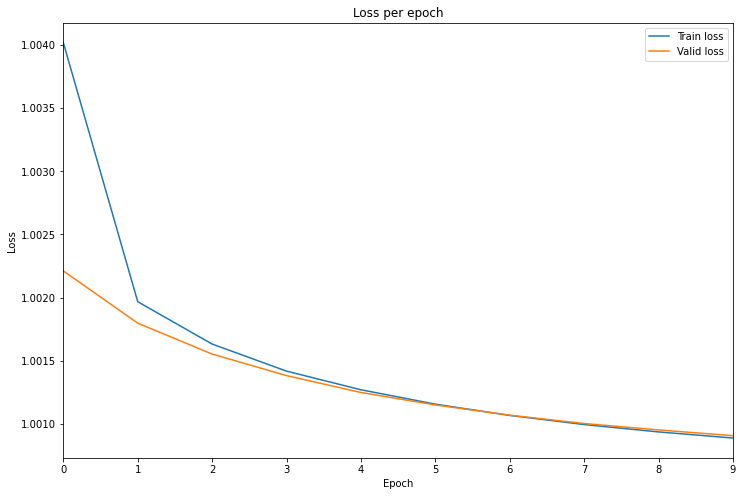

In [65]:
plt.figure(figsize=(12,8))
plt.plot(train_hist.history['loss'], label='Train loss')
plt.plot(train_hist.history['val_loss'], label='Valid loss')
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.linspace(0, epochs-1, epochs))
plt.xlim(0,epochs-1)
plt.legend()
plt.show()

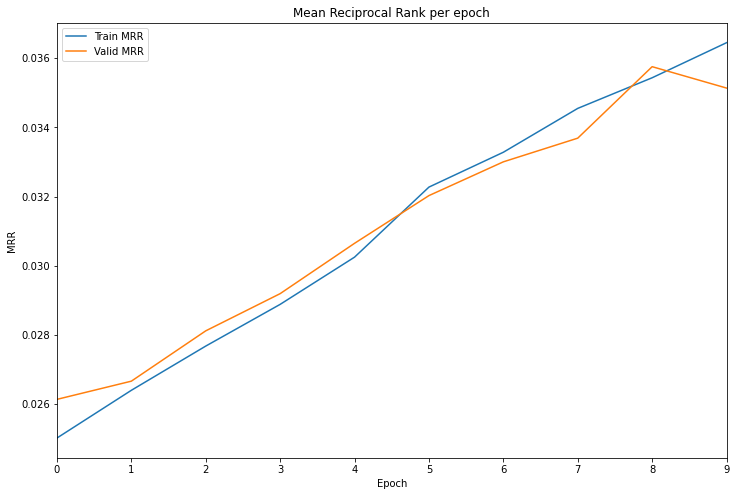

In [64]:
plt.figure(figsize=(12,8))
plt.plot(train_hist.history['mrr'], label='Train MRR')
plt.plot(train_hist.history['val_mrr'], label='Valid MRR')
plt.title('Mean Reciprocal Rank per epoch')
plt.xticks(np.linspace(0, epochs-1, epochs))
plt.xlabel('Epoch')
plt.ylabel('MRR')
plt.xlim(0,epochs-1)
plt.legend()
plt.show()

In [68]:
train_loss = [1.0027, 1.0013, 1.0010, 1.0008, 1.0007, 1.0007, 1.0006, 1.0006, 1.0005, 1.0005, 1.0005, 1.0005, 
              1.0005, 1.0004, 1.0004, 1.0004, 1.0004, 1.0004, 1.0004, 1.0004]
train_mrr = [0.0223, 0.0246, 0.0281, 0.0306, 0.0322, 0.0335, 0.0348, 0.0360, 0.0370, 0.0379, 0.0387, 0.0398, 
             0.0405, 0.0409, 0.0417, 0.0425, 0.0431, 0.0436, 0.0441, 0.0446]
val_loss = [1.0022, 1.0011, 1.0009, 1.0008, 1.0007, 1.0006, 1.0006, 1.0006, 1.0005, 1.0005, 1.0005, 1.0005, 
            1.0005, 1.0004, 1.0004, 1.0004, 1.0004, 1.0004, 1.0004, 1.0004]
val_mrr = [0.0233, 0.0266, 0.0294, 0.0300, 0.0315, 0.0343, 0.0362, 0.0375, 0.0377, 0.0374, 0.0395, 0.0400, 
           0.0414, 0.0407, 0.0404, 0.0433, 0.0439, 0.0450, 0.0429, 0.0434]

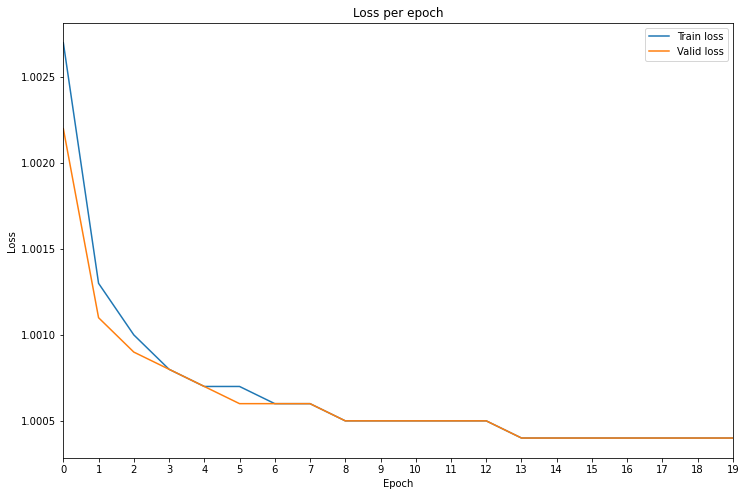

In [71]:
epochs = 20
plt.figure(figsize=(12,8))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Valid loss')
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.linspace(0, epochs-1, epochs))
plt.xlim(0,epochs-1)
plt.legend()
plt.show()

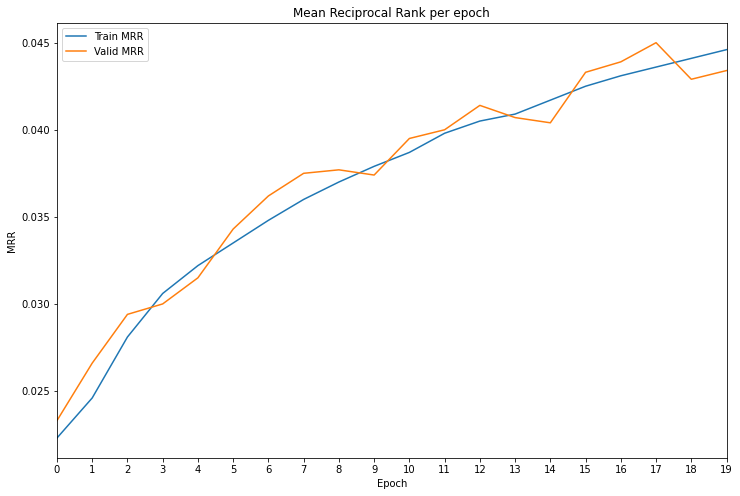

In [69]:
plt.figure(figsize=(12,8))
plt.plot(train_mrr, label='Train MRR')
plt.plot(val_mrr, label='Valid MRR')
plt.title('Mean Reciprocal Rank per epoch')
plt.xticks(np.linspace(0, epochs-1, epochs))
plt.xlabel('Epoch')
plt.ylabel('MRR')
plt.xlim(0,epochs-1)
plt.legend()
plt.show()

# Evaluation

In [37]:
test_df = read_data(scope='valid', n_splits=1)
len(test_df)

15328

In [39]:
train_model.compile(loss=cos_loss, optimizer=optimizer, metrics=[mrr, frank, relevantat1, relevantat5, relevantat10])

In [40]:
eval_res = train_model.evaluate(valid_data, steps=valid_steps_per_epoch)

306/306 [==============================] - 289s 945ms/step - loss: 0.1361 - mrr: 0.4291 - frank: 7.3330 - relevantat1: 0.2686 - relevantat5: 0.6153 - relevantat10: 0.7757


In [41]:
np.round(eval_res, 2)

array([0.14, 0.43, 7.33, 0.27, 0.62, 0.78])

In [ ]:
def get_top_related_functions(desc, sc_list, desc_embedding_model, code_embedding_model): 
    desc_preprocessed = cleaning(desc)
    desc_input = generate_bert_input([desc_preprocessed], desc_max_seq_length)
    desc_vec = desc_embedding_model.predict(desc_input)
    
    sc_t_fname_ids, sc_t_api_ids, sc_t_tok_ids = generate_sc_input(sc_list,
                                                   sc_max_fname_length,
                                                   sc_max_api_length,
                                                   sc_max_seq_length,
                                                   sc_max_vocab_size,
                                                   use_vocab=sc_vocab)[1:]
    sc_vec = code_embedding_model.predict((np.array(sc_t_fname_ids), np.array(sc_t_api_ids), np.array(sc_t_tok_ids)))
    norm_desc = tf.norm(desc_vec, axis=-1, keepdims=True) + 1e-10
    norm_sc   = tf.norm(sc_vec, axis=-1, keepdims=True)   + 1e-10
    cos_similarity = tf.matmul(desc_vec/norm_desc,
                                sc_vec/norm_sc,
                                transpose_a=False,
                                transpose_b=True)
    top_indexes = np.argsort(-cos_similarity)[0]
    return top_indexes, sc_list[top_indexes], cos_similarity.numpy()[0,top_indexes]

In [ ]:
chosen_ind = 35
n_samples = 50
rand_inds = np.append([chosen_ind], np.random.randint(0, len(test_df), size=n_samples))
desc = test_df.docstring[chosen_ind]
sc_list = test_df.code[rand_inds].values

print("Given requirement:\n", test_df.docstring[chosen_ind],'\n')
print("Expected method: ", chosen_ind, "\n", test_df.code[chosen_ind],'\n')

top_k = 10
top_w_sim = get_top_related_functions(desc, sc_list, desc_embedding_model, code_embedding_model)
print(f"Position of ground-truth method in extracted set is {list(top_w_sim[0]).index(chosen_ind)}\n")
print("Predicted methods:")
for ti,jm,sim in zip(*top_w_sim[:top_k]):
    print(ti,':',sim)
    print(jm)
    print('-'*75)

In [128]:
def evaluate_cos_similarity(desc_text, sc_text):
    desc_word_ids, desc_input_mask, desc_segment_ids = generate_bert_input([desc_text], desc_max_seq_length)
    sc_ids = generate_sc_input([sc_text], model, sc_max_seq_length)
    
    res = sim_model.predict((desc_word_ids, desc_input_mask, desc_segment_ids, sc_ids), batch_size=batch_size)

    return res

def evaluate_cos_similarities(desc_texts, sc_texts):
    desc_word_ids, desc_input_mask, desc_segment_ids = generate_bert_input(desc_texts, desc_max_seq_length)
    sc_ids = generate_sc_input(sc_texts, model, sc_max_seq_length)
    
    res = sim_model.predict((desc_word_ids, desc_input_mask, desc_segment_ids, sc_ids), batch_size=batch_size)

    return res

In [186]:
rand_sim_ind = np.random.randint(0, len(train_df))
rand_dif_ind = np.random.randint(0, len(train_df))
print(f"Doc 1: {train_df.docstring[rand_sim_ind]}\n")
print(f"Doc 2: {train_df.docstring[rand_dif_ind]}\n")
sim_matr = evaluate_cos_similarities(train_df.iloc[[rand_sim_ind, rand_dif_ind]].docstring, 
                                     train_df.iloc[[rand_sim_ind, rand_dif_ind]].code_tokens)
print(f"Similaity matrics:\n{sim_matr}")
print(sim_matr >= np.diag(sim_matr))

Doc 1: placeholder  dynamic  @param dynamic

Doc 2: lists annotated datasets for a dataset. pagination is supported. <p>sample code: <pre><code> try (datalabelingserviceclient datalabelingserviceclient = datalabelingserviceclient.create()) { string formattedparent = datalabelingserviceclient.formatdatasetname("[project]", "[dataset]"); string filter = ""; for (annotateddataset element : datalabelingserviceclient.listannotateddatasets(formattedparent, filter).iterateall()) { // dothingswith(element); } } </code></pre> @param parent required. name of the dataset to list annotated datasets, format: projects/{project_id}/datasets/{dataset_id} @param filter optional. filter is not supported at this moment. @throws com.google.api.gax.rpc.apiexception if the remote call fails

Similaity matrics:
[[0.9676776  0.9681637 ]
 [0.9759587  0.97649354]]
[[ True False]
 [ True  True]]


In [208]:
np.greater_equal(sim_matr, np.reshape(np.repeat(np.diag(sim_matr), 2), (2,2)))

array([[ True,  True],
       [False,  True]])